## <center>Predictive Regression</center>

### <center>Get, format and check the data</center>

In [51]:
from helpers import *

returns_portfolio = pd.read_excel('data/Refinitv_MonthlyReturns.xlsx', index_col=0, parse_dates=True)
factor_data = pd.read_excel('data_copulas/Factor_UpsideRatio.xlsx', index_col=0, parse_dates=True)
no_lag_factor_data = factor_data.loc['2006-07-01':'2016-06-01'] # The previous month is used to calculate current month
one_year_lag_factor_data = factor_data.loc['2005-07-01':'2015-06-01']
five_year_lag_factor_data = factor_data.loc['2001-07-01':'2011-06-01']

risk_free_rate = pd.read_excel('data/FF_RF.xlsx', index_col=0, parse_dates=True)[['RF']]
# divide rf by 10 to get the correct decimal format
risk_free_rate = risk_free_rate / 100

returns_portfolio.index = returns_portfolio.index.to_period('M')
risk_free_rate.index = risk_free_rate.index.to_period('M')
no_lag_factor_data.index = no_lag_factor_data.index.to_period('M')
one_year_lag_factor_data.index = one_year_lag_factor_data.index.to_period('M')
five_year_lag_factor_data.index = five_year_lag_factor_data.index.to_period('M')

print("Before Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, no_lag_factor_data)

# Drop NA's
returns_portfolio = returns_portfolio.dropna(axis=1, how='any')
no_lag_factor_data = no_lag_factor_data.dropna(axis=1, how='any')
one_year_lag_factor_data = one_year_lag_factor_data.dropna(axis=1, how='any')
five_year_lag_factor_data = five_year_lag_factor_data.dropna(axis=1, how='any')

# Drop columns which are not in both
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
returns_portfolio = returns_portfolio.drop(columns=set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
no_lag_factor_data = no_lag_factor_data.drop(columns=set(no_lag_factor_data.columns).difference(set(returns_portfolio.columns)))
one_year_lag_factor_data = one_year_lag_factor_data.drop(columns=set(one_year_lag_factor_data.columns).difference(set(returns_portfolio.columns)))
five_year_lag_factor_data = five_year_lag_factor_data.drop(columns=set(five_year_lag_factor_data.columns).difference(set(returns_portfolio.columns)))
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)), '\n')

print("After Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, no_lag_factor_data)

# for the one and five year lagged factor apply the same index as the no lag factor
one_year_lag_factor_data.index = no_lag_factor_data.index
five_year_lag_factor_data.index = no_lag_factor_data.index


# Check if returns and Rf have same decimal format side by side
print(returns_portfolio.iloc[:, :2].head(), '\n')
print(risk_free_rate.head())

Before Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 100)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Factor First Date: 2006-07 Last Date: 2016-06 Shape: (120, 100) 

Columns not in both {'AMGN', 'AEP', 'SLB'}
Columns not in both set() 

After Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 62)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Factor First Date: 2006-07 Last Date: 2016-06 Shape: (120, 62) 

              AXP        VZ
Date                       
2006-07 -0.019000  0.023500
2006-08  0.009174  0.040156
2006-09  0.067374  0.055420
2006-10  0.033595  0.008633
2006-11  0.015748 -0.019942 

             RF
Date           
2006-07  0.0040
2006-08  0.0042
2006-09  0.0041
2006-10  0.0041
2006-11  0.0042


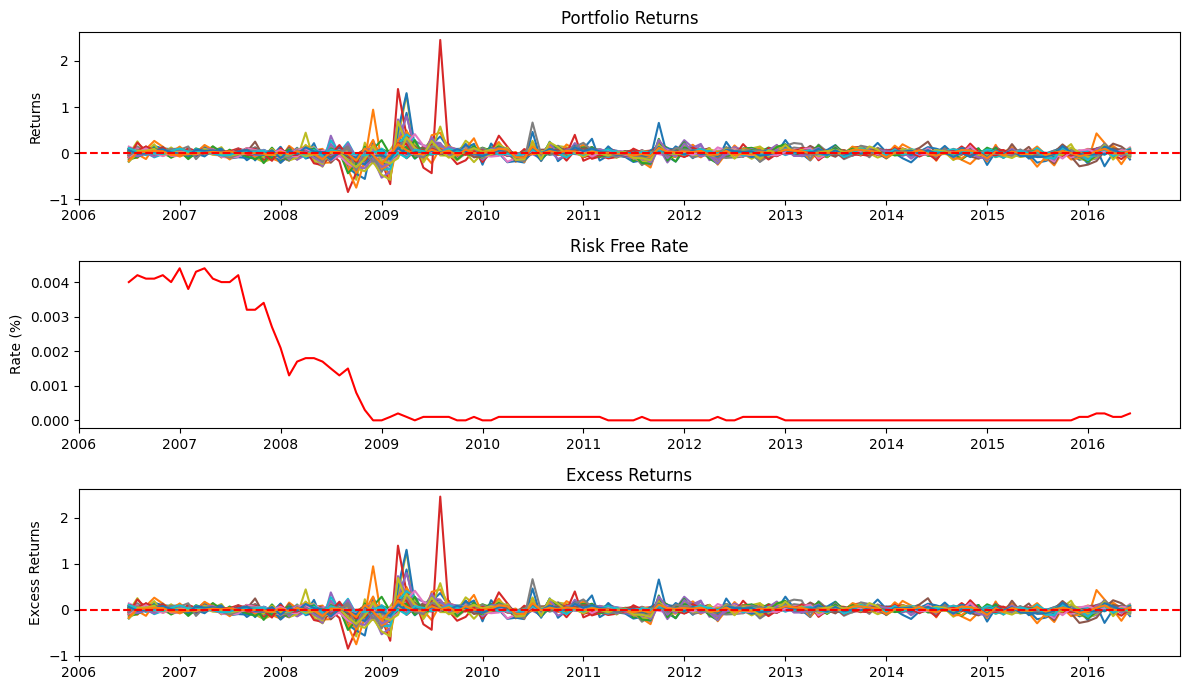

In [52]:
# Calculate the excess returns of the portfolio
excess_returns = returns_portfolio.sub(risk_free_rate['RF'], axis=0)

plot_portf_rf_excess(returns_portfolio, risk_free_rate, excess_returns)

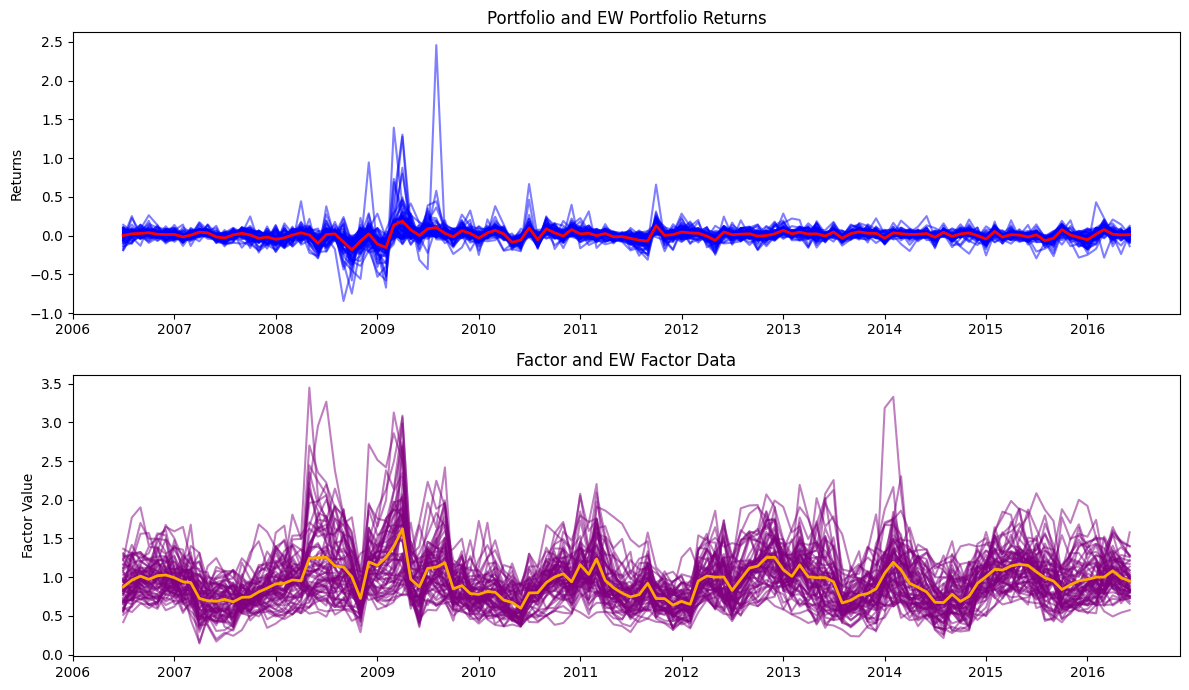

In [53]:
# Construct EW Portfolio and Factor
ew_portfolio_excess_ret = excess_returns.mean(axis=1)
no_lag_ew_factor = no_lag_factor_data.mean(axis=1)
one_year_lag_ew_factor = one_year_lag_factor_data.mean(axis=1)
five_year_lag_ew_factor = five_year_lag_factor_data.mean(axis=1)

ew_portfolio_excess_ret.name = 'EW Portfolio'
no_lag_ew_factor.name = 'EW Factor'
one_year_lag_ew_factor.name = 'EW Factor 1 Year Lag'
five_year_lag_ew_factor.name = 'EW Factor 5 Year Lag'

plot_ew_test(excess_returns, ew_portfolio_excess_ret, no_lag_factor_data, no_lag_ew_factor)

### <center>Run the predictive Regression</center>

$$
Regression Formular: r_{t+k} - r_{f_{t+k}} = a + b \times \ Factor + \epsilon_{t+k}
$$


In [54]:
# Run Regression
X = sm.add_constant(no_lag_ew_factor)
Y = ew_portfolio_excess_ret

no_lag_model = sm.OLS(Y, X)
no_lag_results = no_lag_model.fit()
print('No Lag')
print(no_lag_results.summary(), '\n\n')

X = sm.add_constant(one_year_lag_ew_factor)
Y = ew_portfolio_excess_ret

one_year_lag_model = sm.OLS(Y, X)
one_year_lag_results = one_year_lag_model.fit()
print('One Year Lag')
print(one_year_lag_results.summary(), '\n\n')

X = sm.add_constant(five_year_lag_ew_factor)
Y = ew_portfolio_excess_ret

five_year_lag_model = sm.OLS(Y, X)
five_year_lag_results = five_year_lag_model.fit()
print('Five Year Lag')
print(five_year_lag_results.summary())

No Lag
                            OLS Regression Results                            
Dep. Variable:           EW Portfolio   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.600
Date:                Thu, 13 Jun 2024   Prob (F-statistic):              0.208
Time:                        10:12:07   Log-Likelihood:                 186.18
No. Observations:                 120   AIC:                            -368.4
Df Residuals:                     118   BIC:                            -362.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0227      0.025     -0.919  

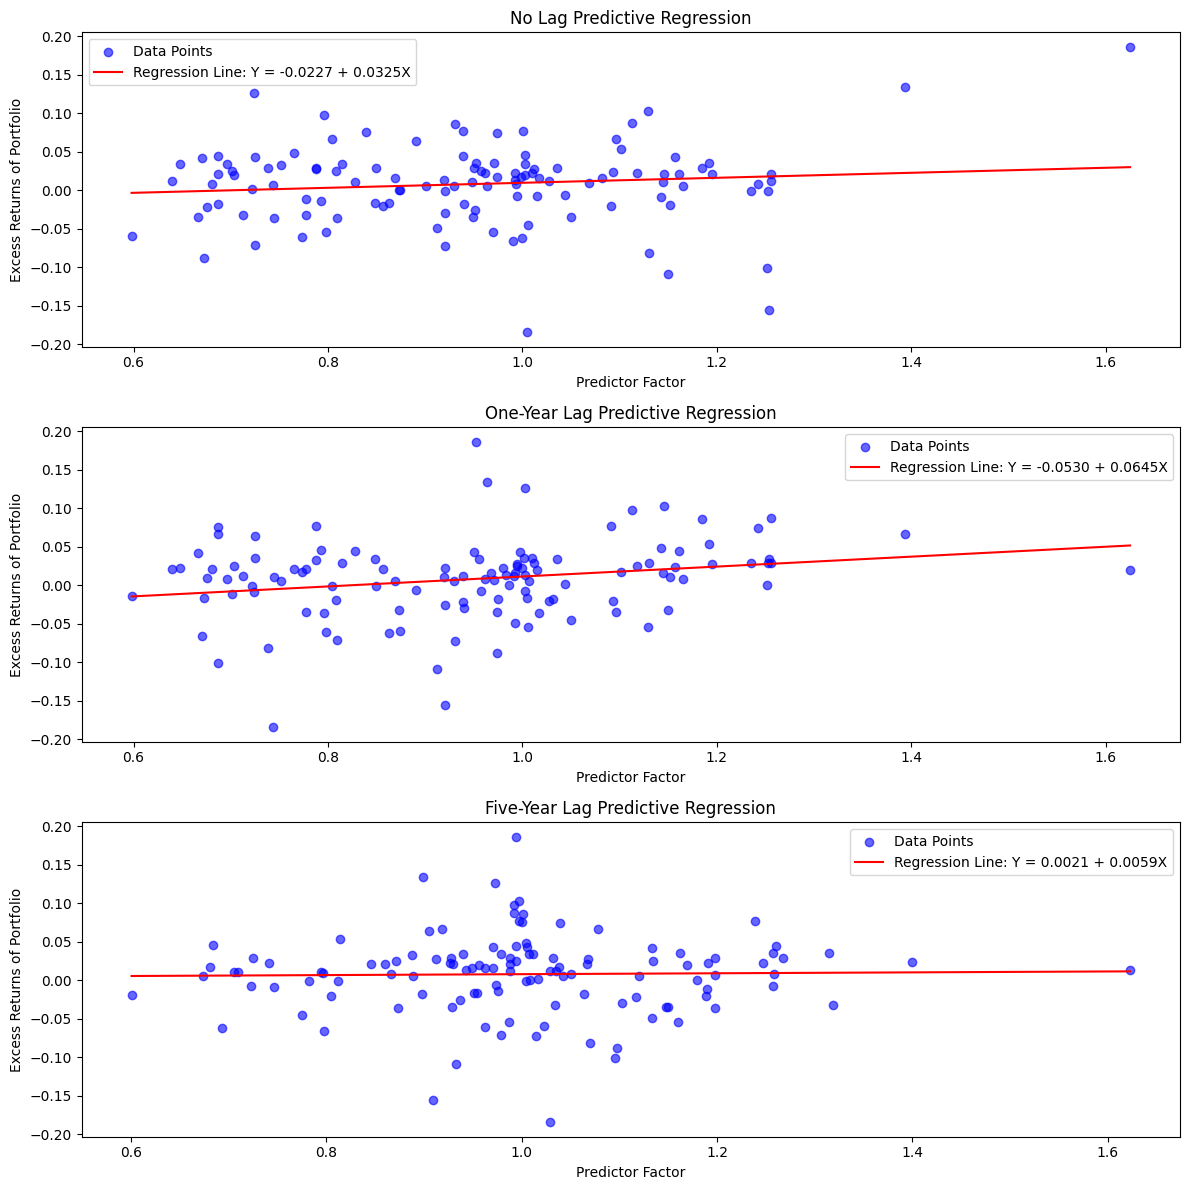

In [55]:
plot_predictive_regressions(ew_portfolio_excess_ret, no_lag_ew_factor, one_year_lag_factor_data.mean(axis=1), five_year_lag_factor_data.mean(axis=1))

### <center>Calculate result metrics</center>

**Standard Deviation of Predicted Excess Returns:**
Measures the variability of the predicted excess returns from their mean.
$$
\sigma [E_t(Re)] = \text{Standard Deviation of } E_t(Re)
$$



**Coefficient of Variation of Predicted Excess Returns:**
Standardizes the standard deviation by the mean of the predicted excess returns, providing a normalized measure of dispersion.
$$
\text{Coefficient of Variation} = \frac{\sigma [E_t(Re)]}{E(Re)}
$$



In [56]:
def get_sigma_pred_and_coef_of_variation(predicted_excess_returns):
    sigma_pred = np.std(predicted_excess_returns)
    mean_pred = np.mean(predicted_excess_returns)
    coef_of_variation = sigma_pred / mean_pred
    return sigma_pred, coef_of_variation

def get_params(results):
    beta_name = results.params.index[1]
    alpha = results.params[0]
    beta = results.params[beta_name]
    t_statistic_beta = results.tvalues[beta_name]
    p_value_beta = results.pvalues[beta_name]
    r_squared = results.rsquared
    return alpha, beta, t_statistic_beta, p_value_beta, r_squared

# Get the predicted excess returns
no_lag_predicted_excess_returns = no_lag_results.fittedvalues
one_year_lag_predicted_excess_returns = one_year_lag_results.fittedvalues
five_year_lag_predicted_excess_returns = five_year_lag_results.fittedvalues

# Get the sigma_pred and coef_of_variation
no_lag_sigma_pred, no_lag_coef_of_variation = get_sigma_pred_and_coef_of_variation(no_lag_predicted_excess_returns)
one_year_lag_sigma_pred, one_year_lag_coef_of_variation = get_sigma_pred_and_coef_of_variation(one_year_lag_predicted_excess_returns)
five_year_lag_sigma_pred, five_year_lag_coef_of_variation = get_sigma_pred_and_coef_of_variation(five_year_lag_predicted_excess_returns)

# Get the rest of the parameters
no_lag_alpha, no_lag_beta, no_lag_t_statistic_beta, no_lag_p_value_beta, no_lag_r_squared = get_params(no_lag_results)
one_year_lag_alpha, one_year_lag_beta, one_year_lag_t_statistic_beta, one_year_lag_p_value_beta, one_year_lag_r_squared = get_params(one_year_lag_results)
five_year_lag_alpha, five_year_lag_beta, five_year_lag_t_statistic_beta, five_year_lag_p_value_beta, five_year_lag_r_squared = get_params(five_year_lag_results)

/var/folders/2_/86b4jc217ysdc4kf9wj_zbgh0000gn/T/ipykernel_51528/1897056357.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = results.params[0]


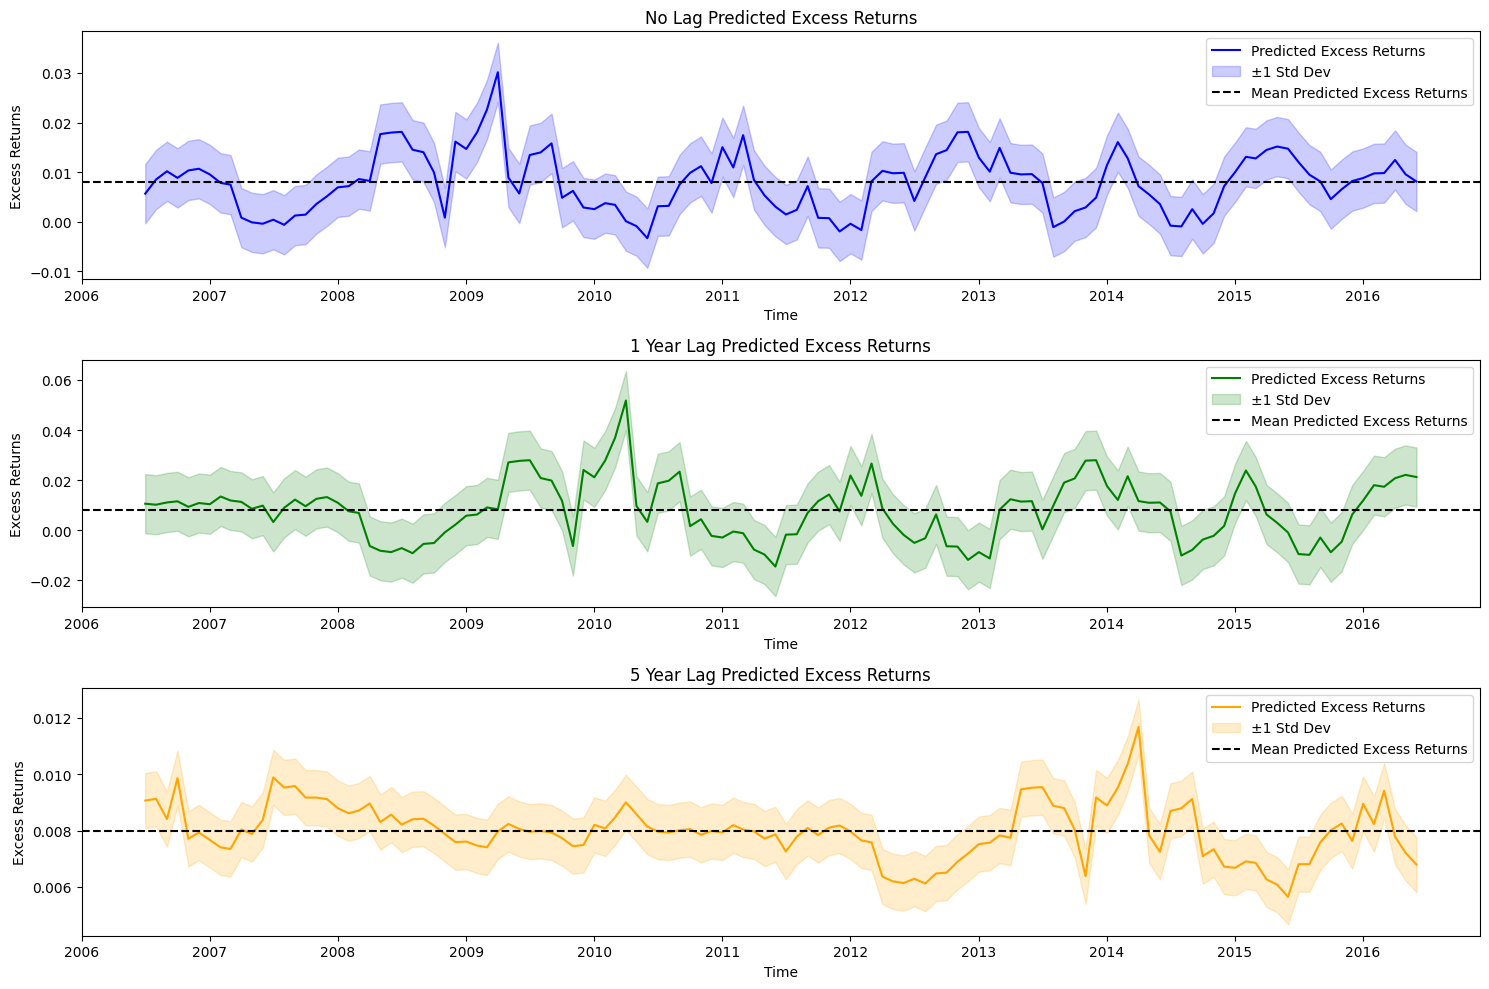

In [57]:
time_index = returns_portfolio.index.to_timestamp()
plot_std_dev_predicted_excess_returns(time_index, no_lag_predicted_excess_returns, one_year_lag_predicted_excess_returns, five_year_lag_predicted_excess_returns)

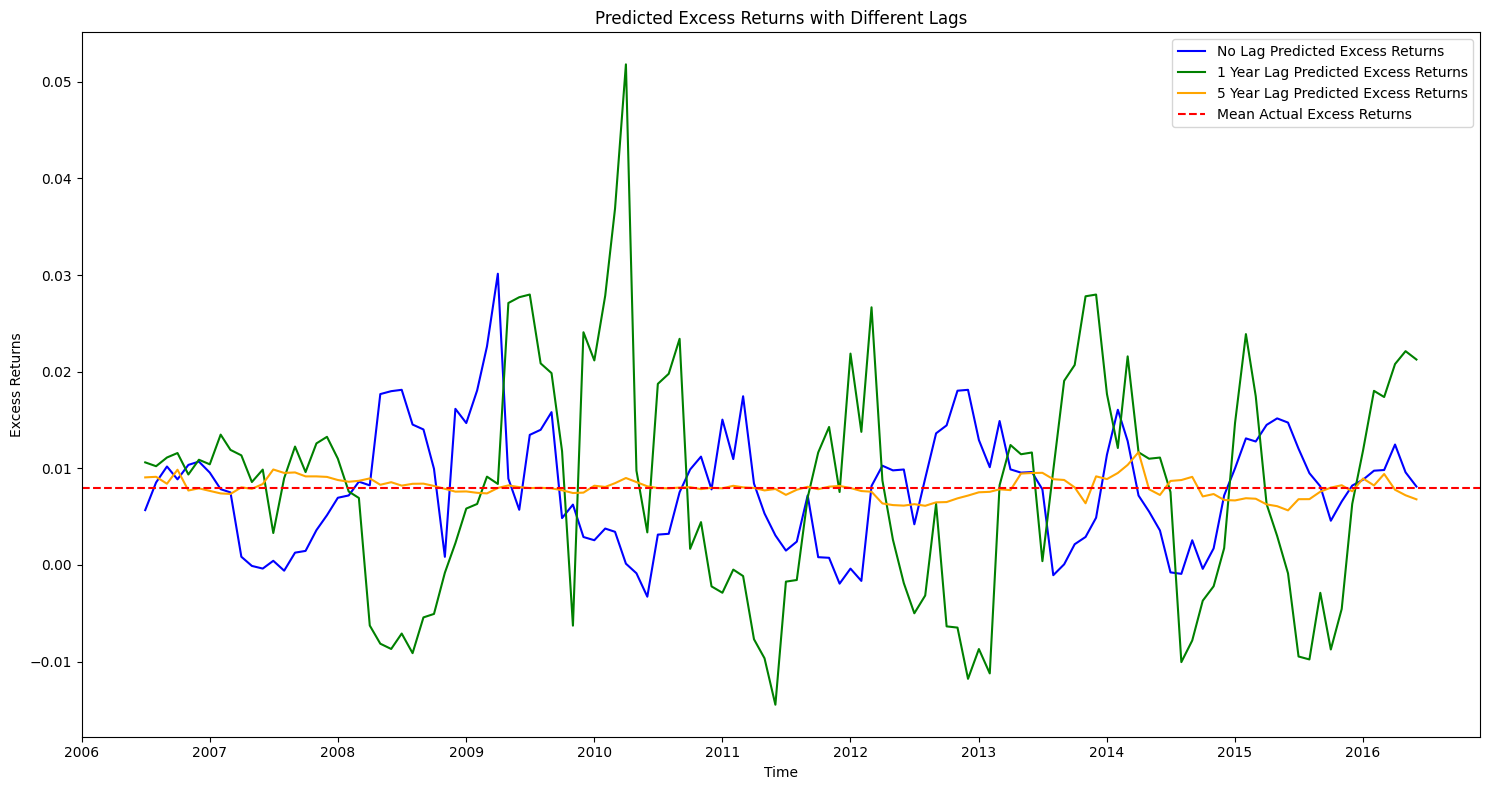

In [58]:
ew_portfolio_excess_ret.index = time_index
plot_combined_predicted_excess_returns(time_index, no_lag_predicted_excess_returns, one_year_lag_predicted_excess_returns, five_year_lag_predicted_excess_returns, ew_portfolio_excess_ret)

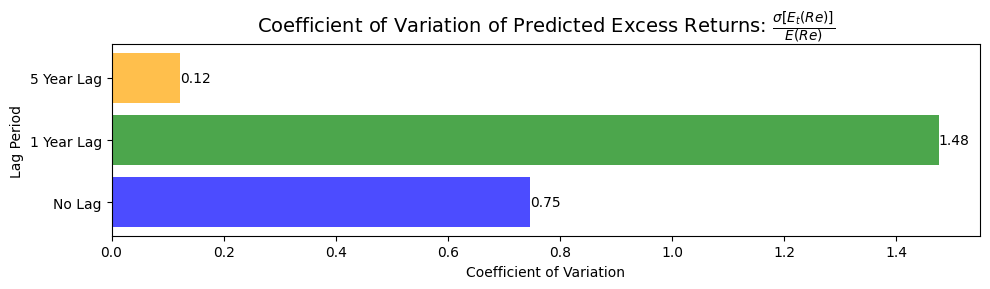

In [59]:
plot_coefficient_of_variation_bars(no_lag_coef_of_variation, one_year_lag_coef_of_variation, five_year_lag_coef_of_variation)

In [60]:
# Create a DataFrame with the results
summary_results_data = {
    "Horizon": ["No Lag", "1 Year Lag", "5 Year Lag"],
    "Alpha": [no_lag_alpha, one_year_lag_alpha, five_year_lag_alpha],
    "Beta": [no_lag_beta, one_year_lag_beta, five_year_lag_beta],
    "T-Statistic of Beta": [no_lag_t_statistic_beta, one_year_lag_t_statistic_beta, five_year_lag_t_statistic_beta],
    "P-Value of Beta": [no_lag_p_value_beta, one_year_lag_p_value_beta, five_year_lag_p_value_beta],
    "R-Squared": [no_lag_r_squared, one_year_lag_r_squared, five_year_lag_r_squared],
    "σ[E_t(Re)]": [no_lag_sigma_pred, one_year_lag_sigma_pred, five_year_lag_sigma_pred],
    "σ[E_t(Re)]/E(Re)": [no_lag_coef_of_variation, one_year_lag_coef_of_variation, five_year_lag_coef_of_variation]
}

summary_results_df = pd.DataFrame(summary_results_data)

display(summary_results_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt')]}]
).set_properties(**{'background-color': 'lightgrey', 'color': 'black', 'border-color': 'white'}))

,Horizon,Alpha,Beta,T-Statistic of Beta,P-Value of Beta,R-Squared,σ[E_t(Re)],σ[E_t(Re)]/E(Re)
0,No Lag,-0.022740,0.032538,1.264772,0.208445,0.013375,0.005970,0.746896
1,1 Year Lag,-0.053040,0.064516,2.548905,0.012089,0.052185,0.011793,1.475322
2,5 Year Lag,0.002115,0.005888,0.205805,0.837298,0.000359,0.000978,0.122334


### <center>Interpretation Summary</center>

**No Lag Scenario:** 
- **Beta:** 0.032
- **Significance:** Not statistically significant with a P-value of 0.208 and T-statistic of 1.26. This indicates that the investment factor has no immediate discernible effect on excess returns.

**1 Year Lag Impact:**
- **Beta:** 0.065
- **Significance:** The relationship is statistically significant (P-value: 0.012; T-statistic: 2.55), suggesting the factor's influence materializes after a year. An increased R-squared to 0.052 indicates a better model fit, capturing more variance in returns due to this factor.
- **Volatility Metrics:** Higher `σ[E_t(Re)]` (0.011793) and `σ[E_t(Re)]/E(Re)` (1.475) indicate increased return volatility and a higher relative standard deviation, respectively. This suggests that when the factor does affect returns, the impact introduces more uncertainty and variation, reflecting potentially higher risk but also possibly higher reward scenarios.

**5 Year Lag Analysis:**
- **Beta:** 0.006
- **Significance:** Lacks statistical significance (P-value: 0.837; T-statistic: 0.206) with an extremely low R-squared of 0.0003, showing that the factor fails to explain the returns over this extended period.
- **Volatility Metrics:** Very low `σ[E_t(Re)]` (0.000978) and `σ[E_t(Re)]/E(Re)` (0.122) reflect minimal return variability and relative standard deviation, suggesting that the factor's influence on returns becomes negligible over longer durations. This indicates a diminishing or absent impact, which might imply stable but unresponsive returns with respect to the factor.

### <center>Conclusion</center>
The effectiveness of the investment factor on portfolio returns shows significant time sensitivity. It has a notable influence at a 1-year lag—implying a delayed response by the market to this factor, which could be due to gradual information absorption or delayed investor reactions. At no lag, the factor does not affect returns, and at a 5-year lag, its impact nearly disappears, indicating that its predictive power diminishes with time. The volatility metrics provide insights into the risk-return profile associated with the factor's timing, highlighting increased risk and potential rewards at shorter lags and diminishing impacts over longer periods. This underscores the importance of timing in leveraging this investment strategy for portfolio management.